In [1]:
# -*- coding: utf-8 -*-
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import torch.optim as optim

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
         #(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat',
#          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn


cfg = {
    'VGG11': [32, 32, 'M', 64, 64, 'M', 128, 128, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
#         if(cfg[vgg_name] == 'VGG13_p'):
#             self.classifier = nn.Linear(256, 100)
#         else:
        self.classifier = nn.Linear(512, 100)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm2d(x)]
                in_channels = x
        #layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

In [4]:
class VGG_p(nn.Module):
    def __init__(self, vgg_name, cfg):
        super(VGG_p, self).__init__()
        self.features = self._make_layers(cfg)
        self.classifier = nn.Linear(cfg[-2], 100)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm2d(x)]
                in_channels = x
        #layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
net_corr = VGG('VGG13').to(device)
net_decorr = VGG('VGG13').to(device)
criterion = nn.CrossEntropyLoss()

In [52]:
PATH_corr = './cifar100_net.pth'
PATH_decorr = './w_decorr/wnet_eye_2.pth'

net_corr.load_state_dict(torch.load(PATH_corr))
net_decorr.load_state_dict(torch.load(PATH_decorr))

<All keys matched successfully>

In [41]:
def cal_acc(net_acc):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net_acc(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return (100 * correct / total)

In [8]:
def cal_importance(net, l_index):
    bias_base = net.features[l_index].bias.data.clone().detach()
    av_corrval = 0

    running_loss = 0.0
    imp_corr_bn = torch.zeros(bias_base.shape[0]).to(device)

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        imp_corr_bn += (((net.features[l_index].weight.grad)*(net.features[l_index].weight.data)) + ((net.features[l_index].bias.grad)*(net.features[l_index].bias.data))).abs().pow(2)

    imp_norm = imp_corr_bn/imp_corr_bn.max()
    
    neuron_order = torch.sort(imp_norm)[1]
    
    return neuron_order

In [9]:
import time

In [10]:
def cal_time(net_acc):
    correct = 0
    total = 0
    
    with torch.no_grad():
        t_s = time.time()
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net_acc(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        t_end = time.time() - t_s
    return (t_end / 10000)

### Ground importance

In [12]:
loss_base_corr = 0
num_stop = 0

for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net_corr(inputs)
        loss = criterion(outputs, labels)
        loss_base_corr += loss.item()
        num_stop += labels.shape[0]
        if(num_stop > 5000):
            break

In [ ]:
imp_order_ground = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    loss_mat = torch.load("./w_decorr/loss_corr_bn_train_"+str(l_index)+".pt")
    imp_order_ground.update({l_index: ((loss_mat - loss_base_corr).abs().sort()[1])})#.sort()[0]})

In [ ]:
loss_base_decorr = 0
num_stop = 0

for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net_decorr(inputs)
        loss = criterion(outputs, labels)
        loss_base_decorr += loss.item()
        num_stop += labels.shape[0]
        if(num_stop > 5000):
            break

In [ ]:
imp_order_ground_decorr = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    loss_mat = torch.load("./w_decorr/loss_bn_train_"+str(l_index)+".pt")
    imp_order_ground_decorr.update({l_index: ((loss_mat - loss_base_decorr).abs().sort()[1])})#.sort()[0]})

### TFO importance

In [13]:
import pickle

In [14]:
with open("./w_decorr/corr/tfo_corr.pkl", 'rb') as f:
    imp_order_tfo = pickle.load(f)

In [ ]:
optimizer = optim.SGD(net_corr.parameters(), lr=0, weight_decay=0)
imp_order_tfo = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    print(l_index)
    imp_order_tfo.update({l_index: cal_importance(net_corr, l_index)})

In [15]:
with open("./w_decorr/decorr/tfo_decorr_eye_2.pkl", 'rb') as f:
    imp_order_tfo_decorr = pickle.load(f)

In [ ]:
optimizer = optim.SGD(net_decorr.parameters(), lr=0, weight_decay=0)
imp_order_tfo_decorr = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    print(l_index)
    imp_order_tfo_decorr.update({l_index: cal_importance(net_decorr, l_index)})

In [ ]:
with open("./w_decorr/decorr/tfo_decorr_eye_2.pkl", 'wb') as f:
    pickle.dump(imp_order_tfo_decorr, f)

### Net-slim importance

In [16]:
imp_order_slim = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    slim_mat = net_corr.features[l_index].weight.data.clone()
    imp_order_slim.update({l_index: ((slim_mat).abs().sort()[1])})

In [17]:
imp_order_slim_decorr = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    slim_mat = net_decorr.features[l_index].weight.data.clone()
    imp_order_slim_decorr.update({l_index: ((slim_mat).abs().sort()[1])})

### L2 importance

In [18]:
imp_order_l2 = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    l2_mat = (net_corr.features[l_index-2].weight.data.clone()).pow(2).sum(dim=(1,2,3))
    imp_order_l2.update({l_index: ((l2_mat).abs().sort()[1])})

In [19]:
imp_order_l2_decorr = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    l2_mat = (net_decorr.features[l_index-2].weight.data.clone()).pow(2).sum(dim=(1,2,3))
    imp_order_l2_decorr.update({l_index: ((l2_mat).abs().sort()[1])})

### Random importance

In [20]:
imp_order_rand = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    rand_mat = torch.tensor((np.random.randint(0,net_corr.features[l_index].bias.shape[0],net_corr.features[l_index].bias.shape[0])))
    imp_order_rand.update({l_index: ((rand_mat).sort()[1])})

In [21]:
imp_order_rand_decorr = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    rand_mat = torch.tensor((np.random.randint(0,net_decorr.features[l_index].bias.shape[0],net_decorr.features[l_index].bias.shape[0])))
    imp_order_rand_decorr.update({l_index: ((rand_mat).sort()[1])})

### Compute based importance

In [24]:
l_imp = []

for layer_index in [3, 6, 10, 13, 17, 20, 24, 27, 31, 34]:
    
    _, _, w_in, h_in = net_corr.features[0:layer_index](torch.zeros(1,3,32,32).to(device)).shape
    
    c_out, c_in, w_f, h_f = net_corr.features[layer_index-3].weight.shape
    
    l_imp.append((c_in*w_f*h_f)*(w_in*h_in)*c_out*(c_out*(c_in*w_f*h_f))**(1/5))
    
l_imp = np.array(l_imp)
l_imp = l_imp/l_imp.sum()

In [25]:
l_imp

array([0.00257669, 0.10137537, 0.05822486, 0.1337656 , 0.07682816,
       0.17650477, 0.10137537, 0.23289944, 0.05822486, 0.05822486])

### Pruning

In [162]:
def cfg_p(prune_ratio, orig_size, save_cfg_corr=0, save_cfg=0):
    cfg_list = []

    for i in range(4):
        cfg_list.append(int(orig_size[2*i]*(1-prune_ratio[2*i])))
        cfg_list.append(int(orig_size[2*i+1]*(1-prune_ratio[2*i+1])))
        cfg_list.append('M')

    cfg_list.append(int(orig_size[8]*(1-prune_ratio[8])))
    cfg_list.append(int(orig_size[9]*(1-prune_ratio[9])))
    cfg_list.append('M')
    
    if(save_cfg == 1):
        with open("./w_decorr/pruned_nets/corr/net_p_corr_iter"+str(prune_iter)+".pkl", 'wb') as f:
            pickle.dump(cfg_list, f)

    elif(save_cfg == 2):
        with open("./w_decorr/pruned_nets/decorr/net_p_decorr_iter"+str(prune_iter)+".pkl", 'wb') as f:
            pickle.dump(cfg_list, f)
    
    return cfg_list

In [157]:
def pruner(net, imp_order, prune_ratio, orig_size, net_type=0):
    
    if(net_type==1):
        cfg = cfg_p(prune_ratio, orig_size, save_cfg=1)
    elif(net_type==2):
        cfg = cfg_p(prune_ratio, orig_size, save_cfg=2)
    else:
        cfg = cfg_p(prune_ratio, orig_size)        
    
    net_pruned = VGG_p('VGG13_p', cfg).to(device)
    bn = [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]
        
    for l in range(len(bn)):
        if(l == 0):
            n_c = int(imp_order[bn[l]].shape[0]*prune_ratio[l])
            order_c = (imp_order[bn[l]][n_c:]).sort()[0]
            
            net_pruned.features[bn[l]-2].weight.data = net.features[bn[l]-2].weight[order_c].data.detach().clone()
            net_pruned.features[bn[l]-2].bias.data = net.features[bn[l]-2].bias[order_c].data.detach().clone()

            net_pruned.features[bn[l]].weight.data = net.features[bn[l]].weight[order_c].data.detach().clone()
            net_pruned.features[bn[l]].bias.data = net.features[bn[l]].bias[order_c].data.detach().clone()    
            net_pruned.features[bn[l]].running_var.data = net.features[bn[l]].running_var[order_c].detach().clone()
            net_pruned.features[bn[l]].running_mean.data = net.features[bn[l]].running_mean[order_c].detach().clone()    
            continue
        
        n_p = int(imp_order[bn[l-1]].shape[0]*prune_ratio[l-1])
        n_c = int(imp_order[bn[l]].shape[0]*prune_ratio[l])

        order_p = (imp_order[bn[l-1]][n_p:]).sort()[0]
        order_c = (imp_order[bn[l]][n_c:]).sort()[0]
        
        net_pruned.features[bn[l]-2].weight.data = net.features[bn[l]-2].weight[order_c][:,order_p].detach().clone()
        net_pruned.features[bn[l]-2].bias.data = net.features[bn[l]-2].bias[order_c].detach().clone()

        net_pruned.features[bn[l]].weight.data = net.features[bn[l]].weight[order_c].detach().clone()
        net_pruned.features[bn[l]].bias.data = net.features[bn[l]].bias[order_c].detach().clone()    
        net_pruned.features[bn[l]].running_var.data = net.features[bn[l]].running_var[order_c].detach().clone()
        net_pruned.features[bn[l]].running_mean.data = net.features[bn[l]].running_mean[order_c].detach().clone()    
    
    n_33 = int(imp_order[33].shape[0]*prune_ratio[-1])
    order_33 = (imp_order[33][n_33:]).sort()[0]

    net_pruned.classifier.weight.data = net.classifier.weight[:,order_33].detach().clone()
    net_pruned.classifier.bias.data = net.classifier.bias.detach().clone()
    
    return net_pruned

### Prune and check accuracy

In [70]:
# def prune_accs(net, order_ground, order_tfo, order_slim, order_l2, order_rand): 
def prune_accs(net, order_tfo, order_slim, order_l2, order_rand, PATH):
    net.load_state_dict(torch.load(PATH))
#     plot_ground = []
    plot_tfo = []
    plot_slim = []
    plot_l2 = []
    plot_rand = []
    ratio = []
    
    for coeff in (np.linspace(0,8/2,5)):    
        orig_size = np.array([net.features[0].weight.shape[0], net.features[3].weight.shape[0], net.features[7].weight.shape[0], net.features[10].weight.shape[0], net.features[14].weight.shape[0], net.features[17].weight.shape[0], net.features[21].weight.shape[0], net.features[24].weight.shape[0], net.features[28].weight.shape[0], net.features[31].weight.shape[0]])
        s = orig_size.sum()
        prune_ratio = coeff*l_imp
        print("Prune ratios: ", (prune_ratio*orig_size).sum()/s)
        
#         net_ground = pruner(net, order_ground, prune_ratio, orig_size)
        net_tfo = pruner(net, order_tfo, prune_ratio, orig_size)
        net_slim = pruner(net, order_slim, prune_ratio, orig_size)
        net_l2 = pruner(net, order_l2, prune_ratio, orig_size)
        net_rand = pruner(net, order_rand, prune_ratio, orig_size)
        
        print("Compute time reduction: ", 1 - cal_time(net_tfo)/cal_time(net_decorr))
        
#         plot_ground.append(cal_acc(net_ground.eval()))
        plot_tfo.append(cal_acc(net_tfo.eval()))
        plot_slim.append(cal_acc(net_slim.eval()))
        plot_l2.append(cal_acc(net_l2.eval()))
        plot_rand.append(cal_acc(net_rand.eval()))
        ratio.append((prune_ratio*np.array([64, 64, 128, 128, 256, 256, 512, 512, 512, 512])).sum()/s)
#     return plot_ground, plot_tfo, plot_slim, plot_l2, plot_rand, ratio
    return plot_tfo, plot_slim, plot_l2, plot_rand, ratio

### Prune vs. accuracy plots

In [65]:
# plot_ground, plot_tfo, plot_slim, plot_l2, plot_rand, xmarks = prune_accs(net_corr, imp_order_ground, imp_order_tfo, imp_order_slim, imp_order_l2, imp_order_rand, PATH_corr) 
plot_tfo, plot_slim, plot_l2, plot_rand, xmarks = prune_accs(net_corr, imp_order_tfo, imp_order_slim, imp_order_l2, imp_order_rand, PATH_corr) 
xmarks = np.floor(np.array(xmarks)*100)

Text(0, 0.5, 'Accuracy')

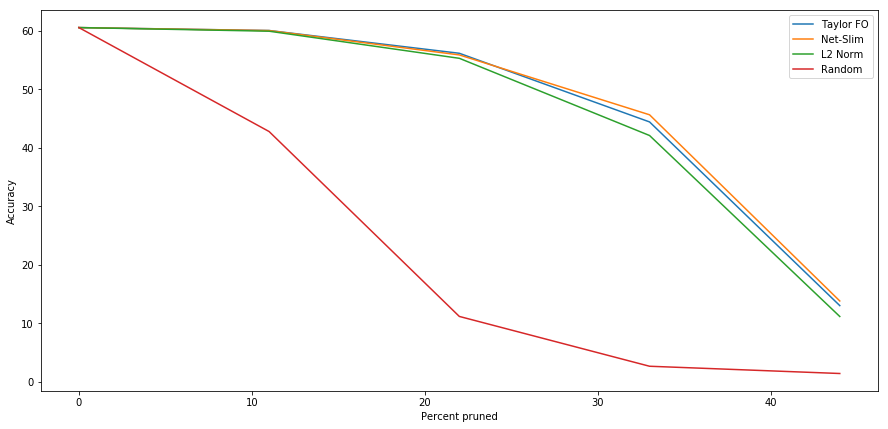

In [66]:
figure(figsize=(15,7))
# plt.plot(xmarks, plot_ground, label="Ground")
plt.plot(xmarks, plot_tfo, label="Taylor FO")
plt.plot(xmarks, plot_slim, label="Net-Slim")
plt.plot(xmarks, plot_l2, label="L2 Norm")
plt.plot(xmarks, plot_rand, label="Random")
plt.legend()
plt.xlabel("Percent pruned")
plt.ylabel("Accuracy")
# plt.savefig("correlated net.png")

In [67]:
# plot_ground_decorr, plot_tfo_decorr, plot_slim_decorr, plot_l2_decorr, plot_rand_decorr, xmarks_decorr = prune_accs(net_decorr, imp_order_ground_decorr, imp_order_tfo_decorr, imp_order_slim_decorr, imp_order_l2_decorr, imp_order_rand_decorr, PATH_decorr) 
plot_tfo_decorr, plot_slim_decorr, plot_l2_decorr, plot_rand_decorr, xmarks_decorr = prune_accs(net_decorr, imp_order_tfo_decorr, imp_order_slim_decorr, imp_order_l2_decorr, imp_order_rand_decorr, PATH_decorr) 
xmarks_decorr = np.floor(np.array(xmarks_decorr)*100)

Text(0, 0.5, 'Accuracy')

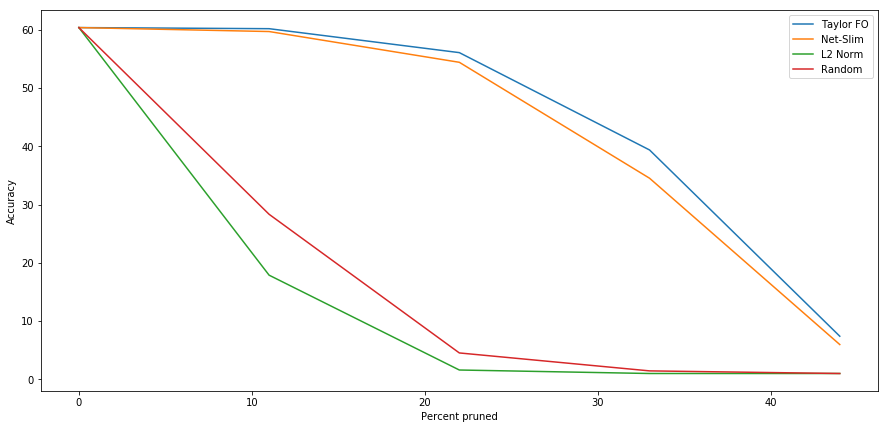

In [68]:
figure(figsize=(15,7))
# plt.plot(xmarks_decorr, plot_ground_decorr, label="Ground")
plt.plot(xmarks_decorr, plot_tfo_decorr, label="Taylor FO")
plt.plot(xmarks_decorr, plot_slim_decorr, label="Net-Slim")
plt.plot(xmarks_decorr, plot_l2_decorr, label="L2 Norm")
plt.plot(xmarks_decorr, plot_rand_decorr, label="Random")
plt.legend()
plt.xlabel("Percent pruned")
plt.ylabel("Accuracy")
# plt.savefig("decorrelated net.png")

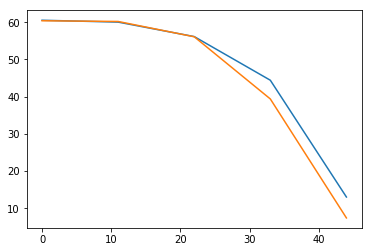

In [69]:
plt.plot(xmarks_decorr, plot_tfo, label="Taylor FO")
plt.plot(xmarks_decorr, plot_tfo_decorr, label="Taylor FO")

In [73]:
plot_tfo, plot_tfo_decorr

([60.52, 60.02, 56.13, 44.4, 13.02], [60.38, 60.19, 56.08, 39.37, 7.4])